## Libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import pickle as pkl

# Meta Population Network

### Plotter

In [2]:
def multi_ploter(t, s, K, i):
# dark blue, orange, red, brown, green, black
    y = 5*i
    
    plt.plot(t, s[:,y+0], label=f'S$_{i}$', color='#000080')
    plt.plot(t, s[:,y+1], label=f'E$_{i}$', color='#FFA500')
    plt.plot(t, s[:,y+2], label=f'I$_{i}$', color='#FF0000')
    plt.plot(t, s[:,y+3], label=f'H$_{i}$', color='#8B4513')
    plt.plot(t, s[:,y+4], label=f'R$_{i}$', color='#008000')
    plt.plot(t, s[:,y+5], label=f'K$_{i}$', color='#000000')
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Fraction of population')
    # display only 3 ticks on the x-axis
    # plt.xticks(np.linspace(0, t[-1], 3))
    # display only 5 ticks on the y-axis
    # plt.yticks(np.linspace(0, 1, 5))
    plt.show()
    return

### Dynamics

In [3]:
def f(s,t):
    # alpha -> a0, a1
    # beta -> b
    # sigma -> si
    # gamma -> g
    # Xi -> x
    # chi -> c
    # epsilon -> e
    # probability -> p

    # Parameters
    global a0, a1, si, b, g, c, x, e, p, l
    # Population network
    global M
    
    # convert s to 2D array
    K = s[-1]
    # remove K from s
    s = np.array(s[:-1])
    s = s.reshape(l, 5)
    s = s.T
    # print(s)
    S, E, I, H, R = s
    K = 1
    N = S + E + I + H + R # Total population
    # print(a0,a1,K)
    a_k = a0 + a1*p*K
    # print(a_k)
    dsdt = np.zeros(l)
    dedt = np.zeros(l)
    didt = np.zeros(l)
    dhdt = np.zeros(l)
    drdt = np.zeros(l)
    dkdt = -c*K
    
    d = M.degree() # degree of each node
    A = nx.adjacency_matrix(M) # adjacency matrix
    A = A.toarray()
    diff_s, diff_e, diff_i, diff_r = np.copy(dsdt), np.copy(dsdt), np.copy(dsdt), np.copy(dsdt) 
    
    for k in range(l):
        Q = np.eye(l)
        Q[:,k] = Q[:,k] - np.ones(l,)
        diff_s[k] = np.dot(A[:,k],np.dot(Q,S))
        diff_e[k] = np.dot(A[:,k],np.dot(Q,E))
        diff_i[k] = np.dot(A[:,k],np.dot(Q,I))
        diff_r[k] = np.dot(A[:,k],np.dot(Q,R))
        

    for i in range(l):
        dsdt[i] = -b[i]*S[i]*I[i]/N[i] + (e/d[i])*diff_s[i]
        dedt[i] = b[i]*S[i]*I[i]/N[i] - si*E[i] + (e/d[i])*diff_e[i]
        didt[i] = si*E[i] - a_k[i]*I[i] + (e/d[i])*diff_i[i]
        dhdt[i] = a_k[i]*I[i] - g*H[i]
        drdt[i] = g*H[i]+ (e/d[i])*diff_r[i]
        dkdt += x*I[i]

    # return 1D array
    temp = []
    for i in range(l):
        temp.append(dsdt[i])
        temp.append(dedt[i])
        temp.append(didt[i])
        temp.append(dhdt[i])
        temp.append(drdt[i])
    temp.append(dkdt)
    return temp

In [4]:
def Gen_Network(n,m):
    M = nx.barabasi_albert_graph(n, m)
    b = 0.03*np.ones(n) #
    return M,b

In [5]:
def IZ(s0,step,e,M):
    I = [] # store all the infected people
    Z = [] # store all the susceptible
    names = ['SD', 'SI', 'SC', 'SB', 'SW']
    global l, p, n
    l = len(M)
    for y in tqdm(range(1,step+1)):
        P = [] # store all the probabilities for SW,SD,SI,SB,SC
        p = np.zeros(n)
        Nd = y/step # fraction of nodes to be provided with kits
        z = int(Nd*l)

        #------------------------------------------------------------
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=False)[:z])
        p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SI
        P.append(p) 
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.clustering(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SC
        P.append(p)
        #------------------------------------------------------------
        p = np.zeros(n)
        temp = np.array(sorted(np.array(list(nx.betweenness_centrality(M).items())), key=lambda x: x[1], reverse=True)[:z])
        # print(temp)
        p[temp[:,0].astype(int)] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SB
        P.append(p)
        #------------------------------------------------------------
        # print(p)

        t = np.linspace(0, 1000,50) # time
        a1 = 0.3
        P.append(np.zeros(n)) # no distribution of testkits

        temp = np.zeros(len(t))

        for j in range(len(P)):
            p = P[j]
            if j == len(P): # no test kits
                a1 = 0
            # print(j,p)
            # print(p)
            s = odeint(f, s0, t)
            pkl.dump(s, open("../Data/s_ER_Imax_" + str(e) + "_" + names[j] + ".pkl" , "wb"))
            K = s[:,-1]
            s = s[:,:-1]            
            temp = np.zeros(len(t))
            temp_z = 0
            for i in range(n):
                y = 5*i
                temp += s[:,y+2]
                temp_z += 100 - s[-1,y]
            I.append(max(temp))
            Z.append(temp_z)

    Imax = np.array(I)
    Zfos = np.array(Z)
    # convert into 2d array
    Imax = Imax.reshape(step,len(P))
    Zfos = Zfos.reshape(step,len(P))
    # colors are green blue dark yellow red and black
    colors = ['#00FF00', '#0000FF', '#8B008B', '#FFD700', '#FF0000', '#000000']
    plt.figure()
    for j in range(len(P)):
        plt.plot(np.linspace(1,step,step)/10, Imax[:,j]/(100*n), label=names[j], color=colors[j],marker='o', markersize=2,linestyle='dashed', linewidth=1)
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('$I_{max}$',size=15)
    # add text
    plt.text(0.9, 0.9, f'epsilon = {e}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()

    plt.figure()
    for j in range(len(P)):
        plt.plot(np.linspace(1,step,step)/10, Zfos[:,j]/(100*n), label=names[j], color=colors[j],marker='o', markersize=2,linestyle='dashed', linewidth=1)
    plt.legend()
    plt.xlabel('p')
    plt.ylabel('$Z_{FOS}$',size=15)
    # add text
    plt.text(0.9, 0.9, f'epsilon = {e}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.show()

In [6]:
a0 = 0.01
a1 = 0.3

# p = np.ones(n)/l # equal distribution of testkits
# p = np.zeros(n)
# temp = np.array(sorted(M.degree(), key=lambda x: x[1], reverse=True)[:2])
# p[temp[:,0]] = temp[:,1]/sum(temp[:,1]) # degree distribution of testkits SD
# print(p)

# n = 100
si = 0.1
g = 0.07
c = 0.1
x = 0.02

### Barabasi Albert Metapopulation Network

#### $I_{max}$

In [7]:
m = 10 # avg degree
n = 50 # number of communities

s0 = []
temp = [99, 1, 0, 0, 0]
for i in range(n):
    de = i+1
    temp = [100-np.round(de/10), de, 0, 0, 0]
    s0 = s0 + temp # S, E, I, H, R
# initial conditions for each community in the network
s0.append(0) # K
step = 10
M,b = Gen_Network(n,m)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_9164/1839745904.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [00:57<00:00,  5.80s/it]


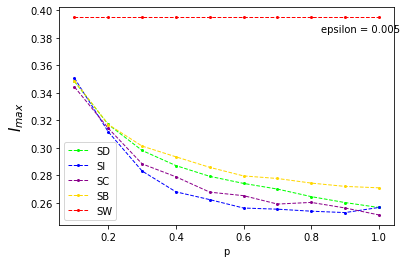

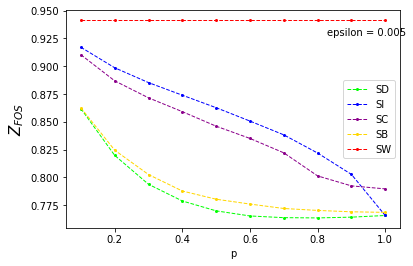

In [8]:
e = 0.005
IZ(s0,step,e,M)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_9164/1839745904.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [01:02<00:00,  6.23s/it]


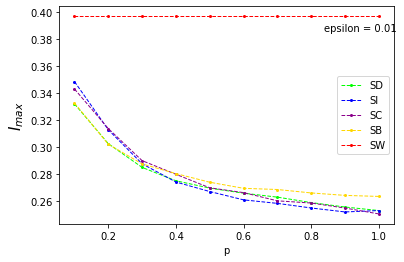

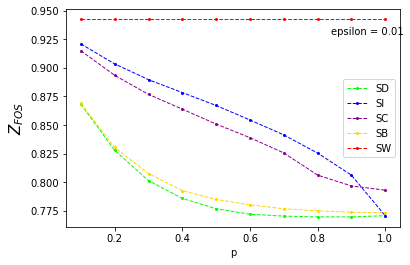

In [9]:
e = 0.01
IZ(s0,step,e,M)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_9164/1839745904.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


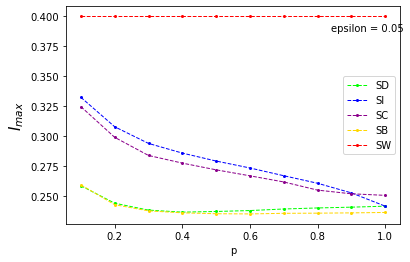

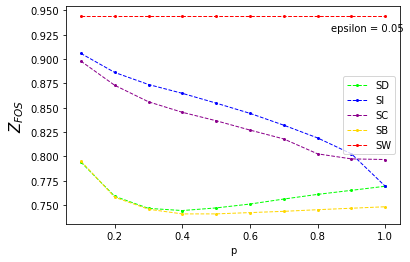

In [10]:
e = 0.05
IZ(s0,step,e,M)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_9164/1839745904.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [02:09<00:00, 13.00s/it]


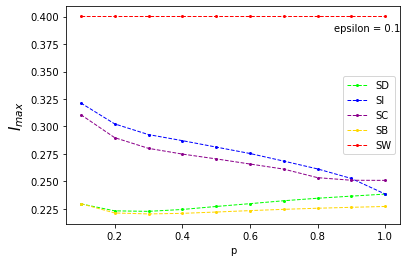

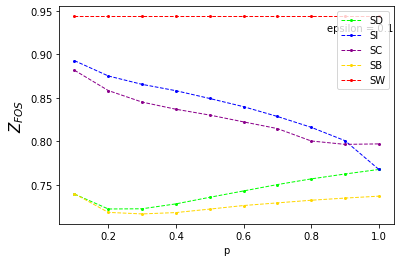

In [11]:
e = 0.1
IZ(s0,step,e,M)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_9164/1839745904.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(M) # adjacency matrix
100%|██████████| 10/10 [04:56<00:00, 29.69s/it]


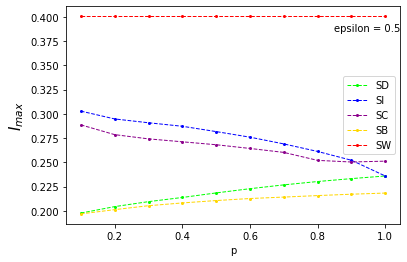

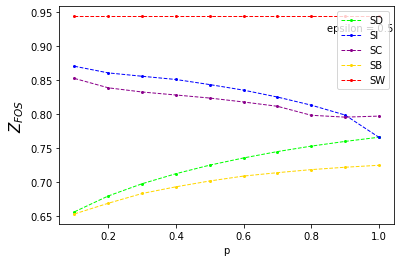

In [12]:
e = 0.5
IZ(s0,step,e,M)